<a href="https://colab.research.google.com/github/Rijan-Ja-Bhattarai/AI/blob/main/FaceRecognitionModelipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import fetch_olivetti_faces
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt

# Research The Data

In [2]:
olivetti_faces = fetch_olivetti_faces(random_state=42)
X = olivetti_faces.data
y = olivetti_faces.target

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [3]:
print(f"Shape: {olivetti_faces.data.shape}")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
type(olivetti_faces.data), type(X), type(y)

Shape: (400, 4096)
Shape of X: (400, 4096)
Shape of y: (400,)


(numpy.ndarray, numpy.ndarray, numpy.ndarray)

## Create Dataset -> Test Train Split

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X , y,
                                                    test_size = 0.2,
                                                    train_size = 0.8,
                                                    random_state = 42)

In [6]:
print(f"Shape of Train sets: {X_train.shape}, {y_train.shape}")
print(f"Shape of Test sets: {X_test.shape}, {y_test.shape}")

Shape of Train sets: (320, 4096), (320,)
Shape of Test sets: (80, 4096), (80,)


## Visualize Dataset

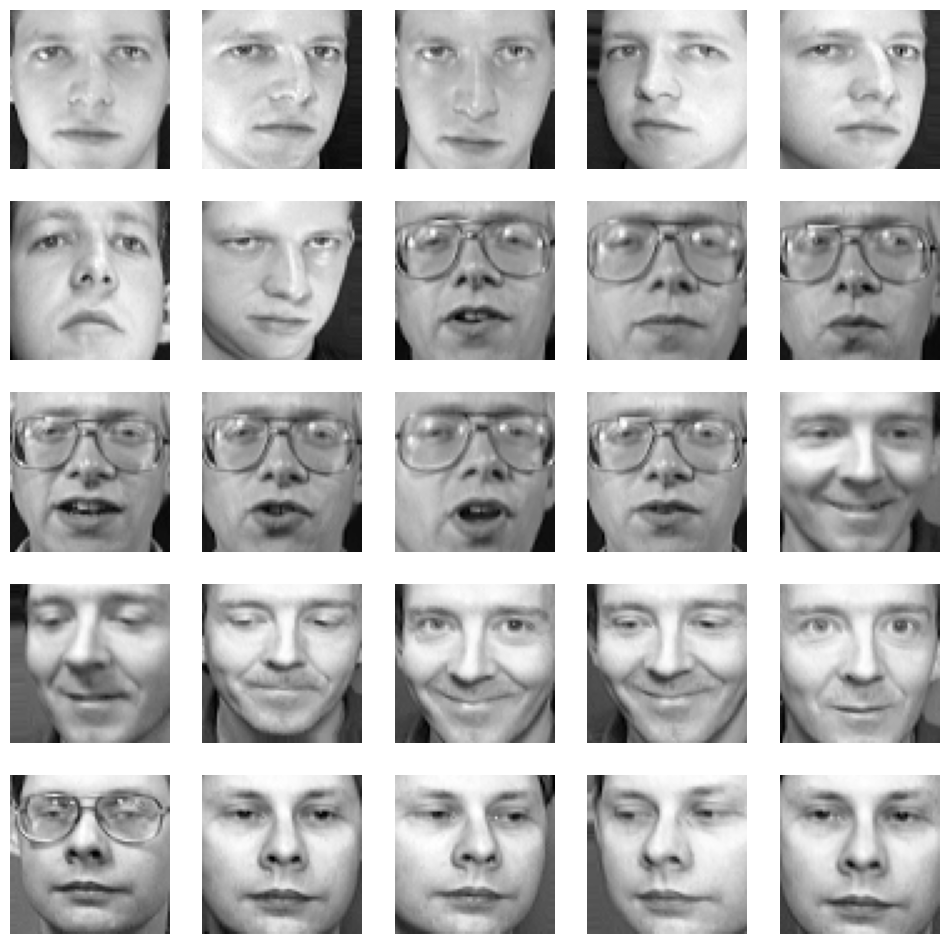

In [7]:
fig, ax = plt.subplots(5, 5, figsize = (12, 12))
for i in range(5):
  for j in range(5):
    index = i * 8 + j # Converts 2D plot into 1D Position
    ax[i, j].imshow(X[index].reshape(64, 64), cmap = "gray") # 64 * 64 = 4096 1 pic has 4096 features
    ax[i, j].axis("off")

# Device Agnostic Code

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current Device Usage: {device}")

Current Device Usage: cuda


# Convert Data Into Tensors

In [9]:
X_train, y_train = torch.from_numpy(X_train), torch.from_numpy(y_train)
X_test, y_test = torch.from_numpy(X_test), torch.from_numpy(y_test)

print(f"Shape of Train sets: {X_train.shape}, {y_train.shape}")
print(f"Shape of Test sets: {X_test.shape}, {y_test.shape}")

Shape of Train sets: torch.Size([320, 4096]), torch.Size([320])
Shape of Test sets: torch.Size([80, 4096]), torch.Size([80])


# Build the Model

In [67]:
class FaceRecognitionModel(nn.Module):
  def __init__(self):
    super().__init__()
    # Define Hidden Layers
    self.Layer1 = nn.Linear(in_features = 4096,
                            out_features = 256)
    self.Layer2 = nn.Linear(in_features = 256,
                            out_features = 40)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.Layer2(self.relu(self.Layer1(x)))

torch.manual_seed(42)
model = FaceRecognitionModel().to(device)
model.state_dict()

OrderedDict([('Layer1.weight',
              tensor([[ 1.1946e-02,  1.2969e-02, -3.6605e-03,  ...,  5.4749e-03,
                       -9.1942e-03,  8.4251e-05],
                      [-1.1069e-02,  1.2576e-02,  1.3178e-02,  ..., -4.5336e-03,
                       -1.1680e-02, -1.1624e-02],
                      [ 8.4296e-05, -2.5167e-03,  1.2165e-02,  ...,  1.1513e-03,
                       -8.1608e-03, -9.0768e-03],
                      ...,
                      [-1.1316e-02,  6.5653e-03,  1.4983e-02,  ..., -1.1134e-02,
                       -2.9868e-03,  8.2615e-03],
                      [ 5.9673e-03, -1.0782e-03,  4.9673e-03,  ..., -4.7530e-03,
                       -1.4411e-02,  8.1008e-03],
                      [-5.3829e-03, -3.5352e-03,  2.3236e-03,  ...,  6.2529e-03,
                        1.2113e-02, -1.2926e-02]], device='cuda:0')),
             ('Layer1.bias',
              tensor([-6.1567e-03,  1.1913e-02,  1.4267e-02,  1.4622e-02,  1.4884e-02,
                    

In [63]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

# If your model is called `model`:
count_parameters(model)


+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
| Layer1.weight |  2097152   |
|  Layer1.bias  |    512     |
| Layer2.weight |   20480    |
|  Layer2.bias  |     40     |
+---------------+------------+
Total Trainable Params: 2118184


2118184

In [12]:
# Convergance
conv = torch.max(X_train)
conv

tensor(1.)

# Train Model

In [97]:
# Loss Function
loss_fn = nn.CrossEntropyLoss()


# Optimization
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = 0.01)

In [98]:
def accuracy_fn(predictions, labels):
    predicted_classes = torch.argmax(predictions, dim=1)  # compute argmax here
    correct = (predicted_classes == labels).sum().item()
    return 100 * correct / labels.size(0)


In [102]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Initialize lists to store metrics
train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []
epoch_values = []

# Move data to the device (CPU or GPU)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Set the number of epochs
epochs = 10000

for epoch in range(epochs):
    # ----------------- Train Mode -----------------
    model.train()  # set model to training mode

    # Forward Pass
    y_pred = model(X_train)

    # Compute Loss
    loss = loss_fn(y_pred, y_train)

    # Compute Accuracy
    train_accuracy = accuracy_fn(y_pred, y_train)

    # Zero the gradients
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Optimizer step
    optimizer.step()

    # ----------------- Testing Mode -----------------
    model.eval()  # set model to evaluation mode
    with torch.inference_mode():
        # Forward Pass
        test_pred = model(X_test)

        # Compute Test Loss
        test_loss = loss_fn(test_pred, y_test)

        # Compute Test Accuracy
        test_accuracy = accuracy_fn(test_pred, y_test)

    # ----------------- Store metrics -----------------
    # Convert tensor losses to floats for storage/plotting
    train_loss_values.append(loss.item())
    test_loss_values.append(test_loss.item())
    train_accuracy_values.append(train_accuracy)
    test_accuracy_values.append(test_accuracy)
    epoch_values.append(epoch)

    # ----------------- Print the output -----------------
    # Print every 1000 epochs
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}/{epochs} | "
              f"Train Loss: {loss.item()} | Train Acc: {train_accuracy:.2f}% | "
              f"Test Loss: {test_loss.item()} | Test Acc: {test_accuracy:.2f}%")


Epoch 0/10000 | Train Loss: 1.2665983817328197e-08 | Train Acc: 100.00% | Test Loss: 2.4958579540252686 | Test Acc: 88.75%
Epoch 1000/10000 | Train Loss: 7.823109271498652e-09 | Train Acc: 100.00% | Test Loss: 2.469665765762329 | Test Acc: 88.75%
Epoch 2000/10000 | Train Loss: 4.470348091700771e-09 | Train Acc: 100.00% | Test Loss: 2.4446542263031006 | Test Acc: 88.75%
Epoch 3000/10000 | Train Loss: 1.4901160305669237e-09 | Train Acc: 100.00% | Test Loss: 2.4172213077545166 | Test Acc: 88.75%
Epoch 4000/10000 | Train Loss: 3.725290076417309e-10 | Train Acc: 100.00% | Test Loss: 2.402972459793091 | Test Acc: 88.75%
Epoch 5000/10000 | Train Loss: 0.0 | Train Acc: 100.00% | Test Loss: 2.399611234664917 | Test Acc: 90.00%
Epoch 6000/10000 | Train Loss: 0.0 | Train Acc: 100.00% | Test Loss: 2.3929080963134766 | Test Acc: 90.00%
Epoch 7000/10000 | Train Loss: 0.0 | Train Acc: 100.00% | Test Loss: 2.387448787689209 | Test Acc: 90.00%
Epoch 8000/10000 | Train Loss: 0.0 | Train Acc: 100.00% | T

# Make Predictions

In [104]:
model.eval()
with torch.inference_mode():
  y_preds = model(X_test)
y_preds[:5]

tensor([[-2105.5977, -2031.0227, -2033.3607, -2019.4446, -2043.9169, -2206.9827,
         -2160.8933, -2207.4980, -2062.4917, -2155.2383, -2098.0449, -2264.2849,
         -2054.6921, -2048.7129, -2029.2867, -2064.7810, -2052.2168, -2100.8357,
         -2159.5032, -2015.2620, -1956.5562, -2073.7617, -2094.2683, -2099.4771,
         -2080.1313, -2045.2777, -2144.6636, -2085.0601, -2031.2903, -2028.8157,
         -2061.4446, -2125.7910, -2029.6481, -2085.1318, -2063.7883, -2028.3611,
         -2102.1853, -2037.4641, -2068.7961, -2018.3477],
        [-3251.5339, -3177.7458, -3168.6978, -3137.2632, -3183.4099, -3541.1172,
         -3311.8157, -3336.0171, -3166.8364, -3284.0454, -3256.7908, -3765.2129,
         -3190.7827, -3158.9656, -3096.8230, -3256.0276, -3188.7009, -3200.2971,
         -3312.6375, -3166.6484, -3116.5759, -3218.0632, -3243.8909, -3208.6431,
         -3182.0215, -3193.1311, -3304.4583, -3209.9702, -3003.9629, -3142.6396,
         -3223.3721, -3276.8884, -3125.0410, -3177.

# Loss Curves

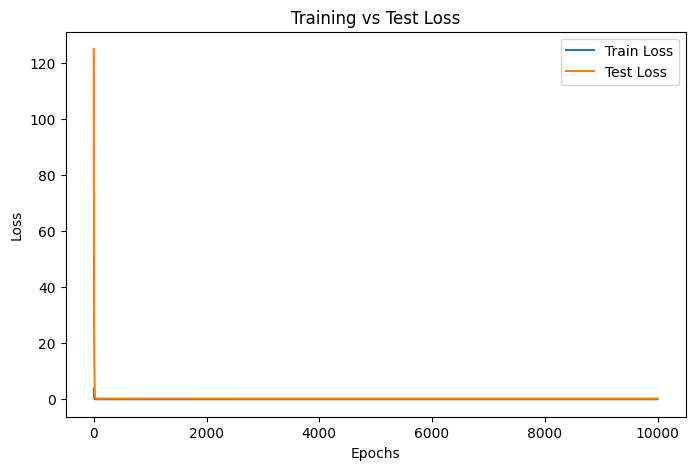

In [95]:
plt.figure(figsize=(8,5))
plt.plot(torch.tensor(epoch_values).cpu().numpy(), torch.tensor(train_loss_values).cpu().numpy(), label="Train Loss")
plt.plot(torch.tensor(epoch_values).cpu().numpy(), torch.tensor(test_loss_values).cpu().numpy(), label="Test Loss")
plt.title("Training vs Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Check if it got it correct or not

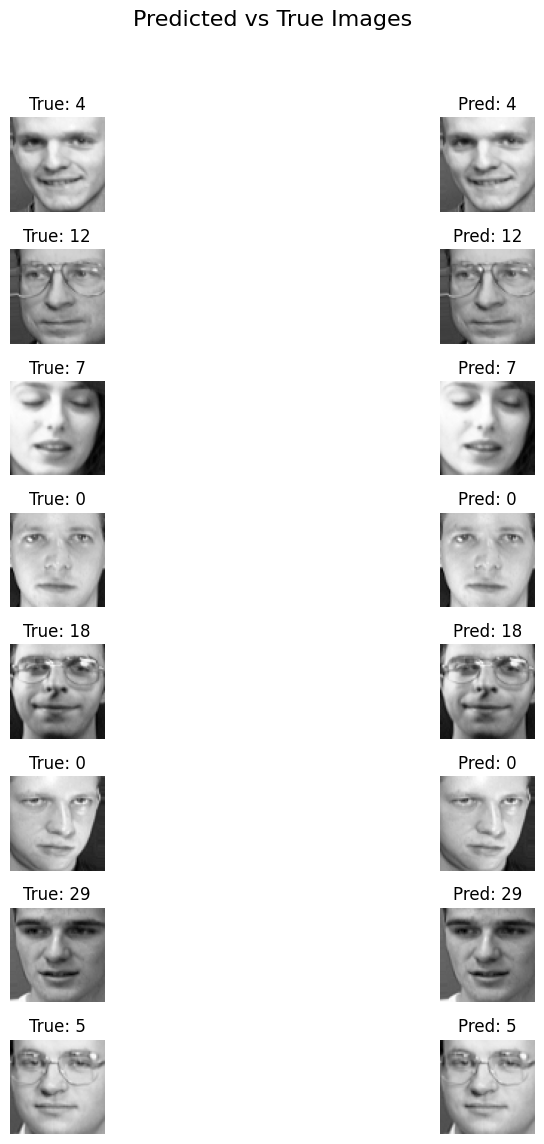

In [109]:
# Get predicted class labels
y_pred_classes = torch.argmax(y_preds, dim=1)

# Move tensors to CPU for plotting
X_test_cpu = X_test.cpu()
y_test_cpu = y_test.cpu()
y_pred_classes_cpu = y_pred_classes.cpu()

# Select a few random indices to visualize
import random
num_images_to_show = 8
random_indices = random.sample(range(len(X_test_cpu)), num_images_to_show)

fig, axes = plt.subplots(nrows=num_images_to_show, ncols=2, figsize=(12, 12))
fig.suptitle('Predicted vs True Images', fontsize=16)

for i, idx in enumerate(random_indices):
    # Display true image and label
    axes[i, 0].imshow(X_test_cpu[idx].reshape(64, 64), cmap='gray')
    axes[i, 0].set_title(f"True: {y_test_cpu[idx].item()}")
    axes[i, 0].axis('off')

    # Display predicted image and label
    axes[i, 1].imshow(X_test_cpu[idx].reshape(64, 64), cmap='gray')
    axes[i, 1].set_title(f"Pred: {y_pred_classes_cpu[idx].item()}")
    axes[i, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
plt.show()